In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [4]:
PATH = '../input'

!ls {PATH}

sample_submission.csv  test.csv  train.csv


In [5]:
df_raw = pd.read_csv(f'{PATH}/train.csv', low_memory=False)

In [6]:
def display_all(df):
    with pd.option_context('display.max_rows',1000):
        with pd.option_context('display.max_columns', 1000):
            display(df);
            
display_all(df_raw.tail().transpose())

,15115,15116,15117,15118,15119
Id,15116,15117,15118,15119,15120
Elevation,2607,2603,2492,2487,2475
Aspect,243,121,134,167,197
Slope,23,19,25,28,34
Horizontal_Distance_To_Hydrology,258,633,365,218,319
Vertical_Distance_To_Hydrology,7,195,117,101,78
Horizontal_Distance_To_Roadways,660,618,335,242,270
Hillshade_9am,170,249,250,229,189
Hillshade_Noon,251,221,220,237,244
Hillshade_3pm,214,91,83,119,164


In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_T

In [8]:
def feature_engineering(df):
    df['HF1'] = df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Fire_Points']
    df['HF2'] = abs(df['Horizontal_Distance_To_Hydrology']-df['Horizontal_Distance_To_Fire_Points'])
    df['HR1'] = abs(df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Roadways'])
    df['HR2'] = abs(df['Horizontal_Distance_To_Hydrology']-df['Horizontal_Distance_To_Roadways'])
    df['FR1'] = abs(df['Horizontal_Distance_To_Fire_Points']+df['Horizontal_Distance_To_Roadways'])
    df['FR2'] = abs(df['Horizontal_Distance_To_Fire_Points']-df['Horizontal_Distance_To_Roadways'])
    df['ele_vert'] = df.Elevation-df.Vertical_Distance_To_Hydrology

    df['slope_hyd'] = (df['Horizontal_Distance_To_Hydrology']**2+df['Vertical_Distance_To_Hydrology']**2)**0.5
    df.slope_hyd=df.slope_hyd.map(lambda x: 0 if np.isinf(x) else x) # remove infinite value if any

    #Mean distance to Amenities 
    df['Mean_Amenities']=(df.Horizontal_Distance_To_Fire_Points + df.Horizontal_Distance_To_Hydrology + df.Horizontal_Distance_To_Roadways) / 3 
    #Mean Distance to Fire and Water 
    df['Mean_Fire_Hyd']=(df.Horizontal_Distance_To_Fire_Points + df.Horizontal_Distance_To_Hydrology) / 2 
    
    df['Neg_Elevation_Vertical'] = df['Elevation']-df['Vertical_Distance_To_Hydrology']
    df['Elevation_Vertical'] = df['Elevation']+df['Vertical_Distance_To_Hydrology']

    df['mean_hillshade'] =  (df['Hillshade_9am']  + df['Hillshade_Noon'] + df['Hillshade_3pm'] ) / 3

    df['Mean_HorizontalHydrology_HorizontalFire'] = (df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Fire_Points'])/2
    df['Mean_HorizontalHydrology_HorizontalRoadways'] = (df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Roadways'])/2
    df['Mean_HorizontalFire_Points_HorizontalRoadways'] = (df['Horizontal_Distance_To_Fire_Points']+df['Horizontal_Distance_To_Roadways'])/2

    df['MeanNeg_Mean_HorizontalHydrology_HorizontalFire'] = (df['Horizontal_Distance_To_Hydrology']-df['Horizontal_Distance_To_Fire_Points'])/2
    df['MeanNeg_HorizontalHydrology_HorizontalRoadways'] = (df['Horizontal_Distance_To_Hydrology']-df['Horizontal_Distance_To_Roadways'])/2
    df['MeanNeg_HorizontalFire_Points_HorizontalRoadways'] = (df['Horizontal_Distance_To_Fire_Points']-df['Horizontal_Distance_To_Roadways'])/2

    df['Slope2'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2+df['Vertical_Distance_To_Hydrology']**2)
    df['Mean_Fire_Hydrology_Roadways']=(df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Roadways']) / 3
    df['Mean_Fire_Hyd']=(df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Hydrology']) / 2 

    df["Vertical_Distance_To_Hydrology"] = abs(df['Vertical_Distance_To_Hydrology'])

    df['Neg_EHyd'] = df.Elevation-df.Horizontal_Distance_To_Hydrology*0.2
    
    return df

In [9]:
df_raw = feature_engineering(df_raw)

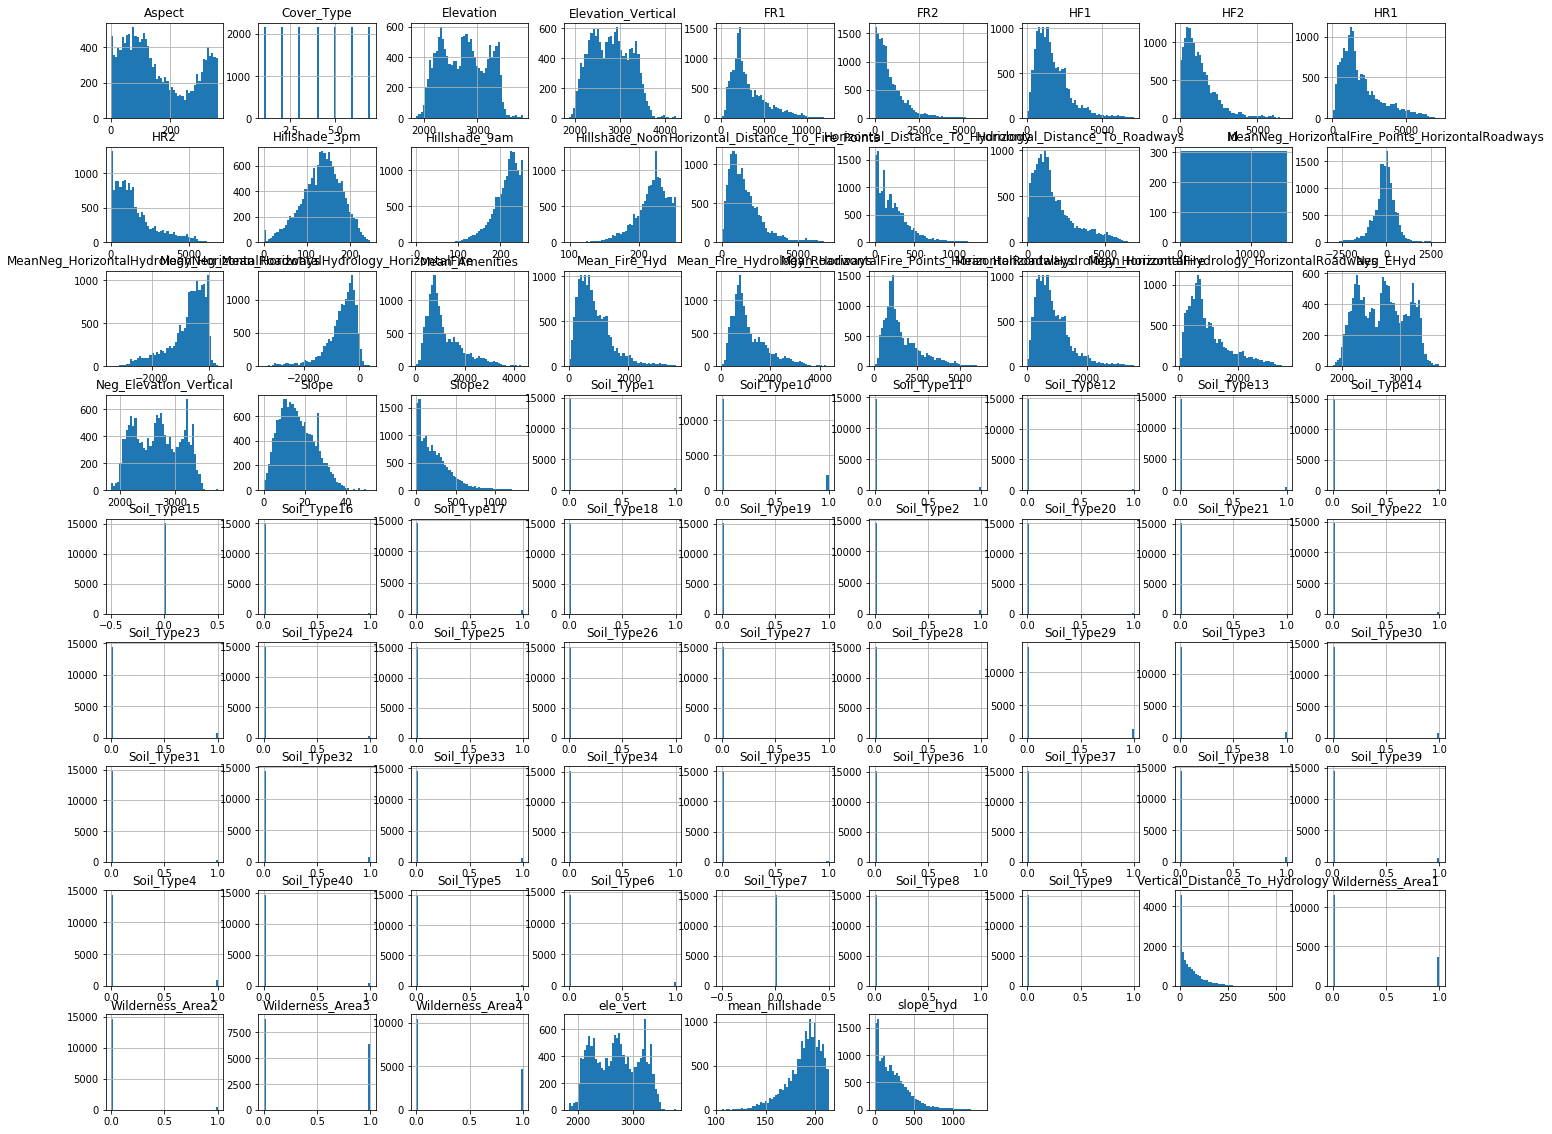

In [10]:
import matplotlib.pyplot as plt
df_raw.hist(bins=50, figsize=(24,20))
plt.show()

In [11]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 78 columns):
Id                                                  15120 non-null int64
Elevation                                           15120 non-null int64
Aspect                                              15120 non-null int64
Slope                                               15120 non-null int64
Horizontal_Distance_To_Hydrology                    15120 non-null int64
Vertical_Distance_To_Hydrology                      15120 non-null int64
Horizontal_Distance_To_Roadways                     15120 non-null int64
Hillshade_9am                                       15120 non-null int64
Hillshade_Noon                                      15120 non-null int64
Hillshade_3pm                                       15120 non-null int64
Horizontal_Distance_To_Fire_Points                  15120 non-null int64
Wilderness_Area1                                    15120 non-null int64
Wilderness_Area

In [12]:
y = df_raw['Cover_Type']
df = df_raw.drop(columns='Cover_Type', axis=1)

In [13]:
from sklearn.model_selection  import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df, y, test_size=0.2, random_state=32)

In [14]:
from sklearn.model_selection import cross_val_score

In [15]:
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

In [16]:
rand_forest_clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features=0.5, random_state=42)
extra_tree_clf=ExtraTreesClassifier(n_estimators=100, min_samples_leaf=1, max_features=0.5, bootstrap=True, random_state=42)
svm_clf = LinearSVC(random_state=42)
log_reg_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)

In [17]:
estimators = [rand_forest_clf, extra_tree_clf, svm_clf, log_reg_clf]

for estimator in estimators:
    print ("Training estimator: ", estimator)
    estimator.fit(X_train, y_train)

Training estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Training estimator:  ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
Training estimator:  LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training estimator:  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [18]:
[estimator.score(X_val, y_val) for estimator in estimators ]

[0.8826058201058201,
 0.8958333333333334,
 0.3376322751322751,
 0.40145502645502645]

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def Stacking(folds, model, df_train, y, df_test):
    n_folds = StratifiedKFold(n_splits=folds, random_state=29).split(df_train, y.values)
    test_pred = np.empty((df_test.shape[0],),float)
    train_pred = np.empty((df_train.shape[0],),float)
    test_pred_skf = np.empty((folds, df_test.shape[0]))
    score = np.empty((0,1), float)
    for i, (x_train_id, x_val_id) in enumerate(n_folds):
        X_train, X_val = df_train.iloc[x_train_id],df_train.iloc[x_val_id]
        y_train, y_val = y.iloc[x_train_id],y.iloc[x_val_id]
        
        model.fit(X_train, y_train)
        train_pred[x_val_id] = model.predict(X_val)
        test_pred_skf[i,:] =  model.predict(df_test)
    test_pred[:] = test_pred_skf.mean(axis=0)
        
    return np.round(test_pred).reshape(-1,1), train_pred.reshape(-1,1)
    
        

def StackedModel(model, X_train, y_train, X_test, folds):
    kf=StratifiedKFold(n_splits=folds, random_state=29)
    train_pred = np.zeros((0,1))
    test_pred = np.zeros((X_test.shape[0],))
    test_pred_skf = np.empty((folds, X_test.shape[0], 7))
        
    for i,(X_train_index, X_val_index) in enumerate(kf.split(X_train, y_train.values)):
        X_tr = X_train.iloc[X_train_index]
        X_te = X_train.iloc[X_val_index]
        y_tr = y_train.iloc[X_train_index]
        
        model.fit(X_tr, y_tr)
        train_pred = np.append(train_pred,model.predict(X_te))
        test_pred_skf[i,:] = model.predict_proba(X_test)
    
    test_pred[:] = test_pred_skf.mean(axis=0)
    return test_pred.reshape(-1,1), train_pred.reshape(-1,1)

len(estimators)

In [19]:
df_test = pd.read_csv(f'{PATH}/test.csv')

In [20]:
df_test = feature_engineering(df_test)

kf=StratifiedKFold(n_splits=5, random_state=1, shuffle=True).split(df, y.values)
train_pred = np.empty((0,1))
test_pred = np.empty((test.shape[0],))
test_pred_skf = np.empty((5, test.shape[0] ,7))
        
for i,(X_train_index, X_val_index) in enumerate(kf):
    X_tr = df.iloc[X_train_index]
    X_te = df.iloc[X_val_index]
    y_tr = y.iloc[X_train_index]
    
    print(i)
    print(len(X_train_index))
    
    rand_forest_clf.fit(X_tr, y_tr)
    train_pred = np.append(train_pred,rand_forest_clf.predict(X_te))
    test_pred_skf[i,:] = log_reg_clf.predict_proba(test)
    test_pred[:] = test_pred_skf[i].mean(axis=1)


len(test_pred)

test_pred

train_pred = pd.DataFrame(train_pred)

train_pred.shape

%%time
#test_pred1 ,train_pred1 = StackedModel(folds=5, model=rand_forest_clf, df_train=df, y=y, df_test = df_test)
test_pred ,train_pred =  StackedModel(folds=5,models=estimators, X_train=df, y_train=y, X_test = df_test)
train_pred = pd.DataFrame(train_pred)
test_pred = pd.DataFrame(test_pred)

test_pred

%%time
#test_pred1 ,train_pred1 = StackedModel(folds=5, model=rand_forest_clf, df_train=df, y=y, df_test = df_test)
test_pred1 ,train_pred1 =  StackedModel(folds=5,models=rand_forest_clf, X_train=df, y_train=y, X_test = df_test)
train_pred1 = pd.DataFrame(train_pred1)
test_pred1 = pd.DataFrame(test_pred1)

%%time
#test_pred2 ,train_pred2 = Stacking(folds=5, model=extra_tree_clf, df_train=df, y=y, df_test = df_test)
test_pred2 ,train_pred2 =  StackedModel(folds=5,model=extra_tree_clf, X_train=df, y_train=y, X_test = df_test)
train_pred2 = pd.DataFrame(train_pred2)
test_pred2 = pd.DataFrame(test_pred2)


test_pred2.describe()

%%time
#test_pred3 ,train_pred3 = Stacking(folds=5, model=svm_clf, df_train=df, y=y, df_test = df_test)
test_pred3 ,train_pred3 =  StackedModel(folds=5,model=svm_clf, X_train=df, y_train=y, X_test = df_test)
train_pred3 = pd.DataFrame(train_pred3)
test_pred3 = pd.DataFrame(test_pred3)


%%time
#test_pred4 ,train_pred4 = Stacking(folds=5, model=log_reg_clf, df_train=df, y=y, df_test = df_test)
test_pred4 ,train_pred4 =  StackedModel(folds=5,model=log_reg_clf, X_train=df, y_train=y, X_test = df_test)
train_pred4 = pd.DataFrame(train_pred4)
test_pred4 = pd.DataFrame(test_pred4)


train_pred4.describe()

df_tr = pd.concat([train_pred1,train_pred2,train_pred3,train_pred4], axis=1)
df_te = pd.concat([test_pred1,test_pred2,test_pred3,test_pred4], axis=1)

df_tr.shape

df_te.head()

rf = RandomForestClassifier(n_estimators = 700)
rf.fit(train_pred.ravel(), y)

preds = rf.predict(test_pred)

In [ ]:
#score1, score2, score3, score4

In [21]:
preds1 = rand_forest_clf.predict(df);
preds2= extra_tree_clf.predict(df);
preds3 = svm_clf.predict(df);
preds4 = log_reg_clf.predict(df);

In [22]:
X_final = pd.DataFrame({'rf':preds1,'et':preds2,'svm':preds3,'log_reg':preds4})
X_final.head(5)

,rf,et,svm,log_reg
0,5,5,1,2
1,5,5,1,2
2,2,2,1,2
3,2,2,1,2
4,5,5,1,5


In [23]:
ID_test = df_test.Id

In [24]:
X_final.tail(), y.tail()

(       rf  et  svm  log_reg
 15115   3   3    3        3
 15116   3   3    3        3
 15117   3   3    3        3
 15118   3   3    3        3
 15119   3   3    3        3, 15115    3
 15116    3
 15117    3
 15118    3
 15119    3
 Name: Cover_Type, dtype: int64)

In [25]:
preds1 = rand_forest_clf.predict(df_test);
preds2= extra_tree_clf.predict(df_test);
preds3 = svm_clf.predict(df_test);
preds4= log_reg_clf.predict(df_test);

In [26]:
X_test_final = pd.DataFrame({'rf':preds1,'et':preds2,'svm':preds3,'log_reg':preds4})
X_test_final.head(5)

,rf,et,svm,log_reg
0,1,1,6,2
1,1,1,6,1
2,1,1,6,1
3,1,1,6,1
4,1,1,6,1


In [29]:
from sklearn.ensemble import VotingClassifier

In [30]:
import xgboost as xgb
from xgboost import XGBClassifier

In [33]:
rf = RandomForestClassifier(n_estimators = 700)
et=ExtraTreesClassifier(n_estimators=700)
svm = LinearSVC(random_state=42)
log_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
xgb = XGBClassifier()

In [45]:
voting_clf = VotingClassifier(estimators=[('rf', rf),('et', et), ('lr', log_reg),('xgb', xgb)], voting='soft')

voting_clf.fit(X_final, y)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [46]:
preds = voting_clf.predict(X_test_final)

rf = RandomForestClassifier(n_estimators = 700)
rf.fit(X_final, y)

#preds = rf.predict(X_test_final)

In [47]:
submission = pd.DataFrame({
    "ID": df_test.Id,
    "Cover_Type": preds
})
submission.to_csv('my_submission.csv', index=False)

In [48]:
submission.head()

,ID,Cover_Type
0,15121,1
1,15122,1
2,15123,1
3,15124,1
4,15125,1
